In [1]:
import sys, os
from importlib import reload
import json, csv

import math , pywt , numpy as np, pandas as pd
import scipy.stats as stats, scipy.signal as signal

from IPython.display import display, HTML
from matplotlib import pyplot as plt


from utils import *
import constants
reload(constants)
from constants import *

--> Importing lhipa_utils module file.



## Config & functions

In [2]:
#---------------------------------------------------
#
# Config *** TO UPDATE ***
#
#---------------------------------------------------
EYE_IMOTIONSFEATURES_AND_AOIS_FILE = DATA_DIR + r'\eventsDataWithAois.csv' 
PERCEIVED_DIFFICULTY_DATA = DATA_DIR + r'\perceivedDifficulty.csv'
EYEMIND_FULL_DATA = DATA_DIR + r'\allDataEyeMind.csv'
PUPIL_FILTERED_FILE = DATA_DIR + r'\PupilData_filtered.csv'
ANSWERS_DATA = DATA_DIR + r'\answers.csv'

QUESTION_FILE_PARSED = ORIG_DIR + r'\QuestionSetParsed.csv'
QUESTION_DETAILS = ORIG_DIR + r'\QuestionDetails.csv'

DEMOGRAPHIC_DATA = DATA_DIR + r'\surveys.csv'
DEMOGRAPHIC_CATALOG_DATA = DATA_DIR + r'\surveys_catalog.json'
DEMOGRAPHIC_RCATALOG_DATA = DATA_DIR + r'\surveys_rcatalog.json'


In [3]:
def mappingOtherQuestionsToMainQuestion(arr,mod):

    # Filter array to keep only elements divisible by mod
    filtered_arr = [x for x in arr if x % mod == 0]

    # Create dictionary with key = element and value = element-mod-1
    result_dict = {x: x-(mod-1) for x in filtered_arr}

    return result_dict

In [4]:
def compute_grouped_mean(df, group_cols, group_cols_not_for_overall_mean, measure_col, measure_out=None, additional_filters=None):
 
    # Apply additional filters if provided
    if additional_filters:
        for key, value in additional_filters.items():
            df = df[df[key] == value]
    

    # Group by group_cols and calculate the mean for each measure
    grouped_means = df.groupby(group_cols+group_cols_not_for_overall_mean)[[measure_col]].mean().reset_index()
    
    
    # Drop participant and question columns from group columns and compute the mean
    overall_mean = grouped_means.groupby(group_cols,as_index=False)[[measure_col]].mean()

    #rename to match the expected column names of what coming afterwards
    if measure_out:
        overall_mean = overall_mean.rename(columns={
            measure_col: measure_out
        })
    
    return overall_mean

In [5]:
def compute_grouped_mean_fixationCount(df,  group_cols, group_cols_not_for_overall_mean, measure_col, measure_out=None, additional_filters=None):
 
    # Apply additional filters if provided
    if additional_filters:
        for key, value in additional_filters.items():
            df = df[df[key] == value]
    
    # Group by group_cols and calculate the mean for each measure
    grouped_means = df.groupby(group_cols+group_cols_not_for_overall_mean)[[measure_col]].count().reset_index()
    
    # Drop participant and question columns from group columns and compute the mean
    overall_mean = grouped_means.groupby(group_cols,as_index=False)[[measure_col]].mean()
    
    #rename to match the expected column names of what coming afterwards
    if measure_out:
        overall_mean = overall_mean.rename(columns={
            measure_col: measure_out
        })

    return overall_mean

In [6]:
def inf_test(data, group_cols, measure_col, sub_col, conditions, additional_filters=None):

    # Apply additional filters if provided
    if additional_filters:
        for key, value in additional_filters.items():
            data = data[data[key] == value]
            
    # Group by group_cols and calculate the mean
    data = data.groupby(group_cols,as_index=False).agg({measure_col:'mean'})
    
    #regroup by the first n elements of the group_calls and compute mean
    # to do: adjust later to consider only one data point per participant
    # now it is two data points per participant
    all_stats = []
    p_values = []
    for cat1, cat2 in conditions:
        
        print(cat1,' vs. ',cat2)
        
        data_cat1 = data.loc[(data[sub_col]==cat1)][group_cols[:3]+[measure_col]].dropna()
        data_cat2 = data.loc[(data[sub_col]==cat2)][group_cols[:3]+[measure_col]].dropna()
        

        merged = data_cat1.merge(data_cat2, on=group_cols[:2], suffixes=('_cat1', '_cat2'), how='inner')
        
        # Calculate Wilcoxon test
        stat, p = stats.wilcoxon(merged[f'{measure_col}_cat1'], merged[f'{measure_col}_cat2'])
       
        # Display in green if p < 0.05, else red
        color = 'green' if p < 0.05 else 'red'
        display(HTML(f"<span style='color: {color};'>{cat1} vs {cat2}: p-value = {p}</span>"))

        all_stats.append(stat)
        p_values.append(p)

    return all_stats, p_values

In [7]:
def inf_test_fixationCount(data, group_cols, measure_col, sub_col, conditions, additional_filters=None):
    
    # Apply additional filters if provided
    if additional_filters:
        for key, value in additional_filters.items():
            data = data[data[key] == value]
            
    # Group by group_cols and calculate the count
    data = data.groupby(group_cols,as_index=False).agg({measure_col:'count'})
    
    #regroup by the first n elements of the group_calls and compute mean
    # to do: adjust later to consider only one data point per participant
    # now it is two data points per participant
    all_stats = []
    p_values = []    
    for cat1, cat2 in conditions:
        
        print(cat1,' vs. ',cat2)

        data_cat1 = data.loc[(data[sub_col]==cat1)][group_cols[:3]+[measure_col]].dropna()
            
        data_cat2 = data.loc[(data[sub_col]==cat2)][group_cols[:3]+[measure_col]].dropna()
                      
        merged = data_cat1.merge(data_cat2, on=group_cols[:2], suffixes=('_cat1', '_cat2'), how='inner')
        
        # Calculate Wilcoxon test
        stat, p = stats.wilcoxon(merged[f'{measure_col}_cat1'], merged[f'{measure_col}_cat2'])
       
        # Display in green if p < 0.05, else red
        color = 'green' if p < 0.05 else 'red'
        display(HTML(f"<span style='color: {color};'>{cat1} vs {cat2}: p-value = {p}</span>"))

        all_stats.append(stat)
        p_values.append(p)

    return all_stats, p_values

In [8]:
def identifyTransition(data,rowIndex, familiarized = False):
    # check that the last row is not reached yet
    if rowIndex<data.shape[0]-1:
        # check that the participant, task and tabName are the same
        if data.iloc[rowIndex]['participant']==data.iloc[rowIndex+1]['participant'] and data.iloc[rowIndex]['currentQuestion']==data.iloc[rowIndex+1]['currentQuestion']  and data.iloc[rowIndex]['tabName']==data.iloc[rowIndex+1]['tabName']:
            if familiarized: # add column 'Familiarized'
                return pd.Series([data.iloc[rowIndex]['participant'], data.iloc[rowIndex]['Familiarized'],data.iloc[rowIndex]['currentQuestion'],data.iloc[rowIndex]['Type1'],data.iloc[rowIndex]['Type3'],data.iloc[rowIndex]['Type4'],data.iloc[rowIndex]['tabName'],data.iloc[rowIndex]['element'], data.iloc[rowIndex+1]['element'],data.iloc[rowIndex]['ComparisionGroup']]) 
        return pd.Series([data.iloc[rowIndex]['participant'],data.iloc[rowIndex]['currentQuestion'],data.iloc[rowIndex]['Type1'],data.iloc[rowIndex]['Type3'],data.iloc[rowIndex]['Type4'],data.iloc[rowIndex]['tabName'],data.iloc[rowIndex]['element'], data.iloc[rowIndex+1]['element'],data.iloc[rowIndex]['ComparisionGroup']]) 
    return pd.Series([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan]) 

#'participant','currentQuestion','Type1','tabName','TransitionSource','TransitionTarget','ComparisionGroup'

def compute_grouped_mean_AOIRunCount(df, group_cols, group_cols_not_for_overall_mean, measure_col, additional_filters=None):
 
    # Apply additional filters if provided
    if additional_filters:
        for key, value in additional_filters.items():
            df = df[df[key] == value]
 
    # Group by group_cols and calculate the mean for each measure
    grouped_means = df.groupby(group_cols+group_cols_not_for_overall_mean)[[measure_col]].count().reset_index()
    
    # Drop participant and question columns from group columns and compute the mean
    overall_mean = grouped_means.groupby(group_cols,as_index=False)[[measure_col]].mean()

    return overall_mean

def inf_test_AOIRunCount(data, group_cols, measure_col, sub_col, conditions, additional_filters=None):
    # Apply additional filters if provided
    if additional_filters:
        for key, value in additional_filters.items():
            #print(key,value)
            data = data[data[key] == value]

    # Group by group_cols and calculate the count
    data = data.groupby(group_cols,as_index=False).agg({measure_col:'count'})

    #regroup by the first n elements of the group_calls and compute mean
    # to do: adjust later to consider only one data point per participant
    # now it is two data points per participant
    
    for cat1, cat2 in conditions:

        print(cat1, 'vs.' ,cat2)

        data_cat1 = data.loc[(data[sub_col]==cat1)][group_cols[:3]+[measure_col]].dropna()
        data_cat2 = data.loc[(data[sub_col]==cat2)][group_cols[:3]+[measure_col]].dropna()
        

        merged = data_cat1.merge(data_cat2, on=group_cols[:2], suffixes=('_cat1', '_cat2'), how='inner')

        # Calculate Wilcoxon test
        stat, p = stats.wilcoxon(merged[f'{measure_col}_cat1'], merged[f'{measure_col}_cat2'])
       
        # Display in green if p < 0.05, else red
        color = 'green' if p < 0.05 else 'red'
        display(HTML(f"<span style='color: {color};'>{cat1} vs {cat2}: p-value = {p}</span>"))

In [9]:
# LHIPA is expected to decrease with increased cognitive load
def compute_lhipa(df):
    # Compute LHIPA with default 'sym5' wavelet
    return lhipa(df['pupilSize'], df['Timestamp'])

In [10]:
def plotComparison(pivot_df,y_label = None):
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    pivot_df.plot(kind='bar', ax=ax)
    plt.title('Comparison')
    if y_label: plt.ylabel(y_label)
    plt.xlabel('Type')
    plt.tight_layout()
    plt.show()


In [11]:
def my_wilcoxon(s1, s2):
    stat, p = stats.wilcoxon(s1, s2)
    return {'stat': stat, 'p': p, 'm1': np.mean(s1), 'm2': np.mean(s2)}


## Load data
Based on the tests in the Data suitability notebook. The data are prepared (read, cleaned, etc.) and some additional informations coming from the different surveys.

In [12]:
# Load Store DataFrames - Pickling
if os.path.isdir(DATA_DIR + 'pkl'):
    eifaData = pd.read_pickle(DATA_DIR + 'pkl' + r'\eifaData.pkl')
    perceivedDifficultyData = pd.read_pickle(DATA_DIR + 'pkl' + r'\perceivedDifficultyData.pkl')
    answersData = pd.read_pickle(DATA_DIR + 'pkl' + r'\answersData.pkl')
    questionsFileParsed = pd.read_pickle(DATA_DIR + 'pkl' + r'\questionsFileParsed.pkl')
    eyeMindFullData = pd.read_pickle(DATA_DIR + 'pkl' + r'\eyeMindFullData.pkl')
    pupiFiltered = pd.read_pickle(DATA_DIR + 'pkl' + r'\pupiFiltered.pkl')


    # Augmented versions (with demographic data)
    demogData = pd.read_pickle(DATA_DIR + 'pkl' + r'\demogData.pkl')
    eifaData2 = pd.read_pickle(DATA_DIR + 'pkl' + r'\eifaData2.pkl')
    pupiFiltered2 = pd.read_pickle(DATA_DIR + 'pkl' + r'\pupiFiltered2.pkl')
    perceivedDifficultyData2 = pd.read_pickle(DATA_DIR + 'pkl' + r'\perceivedDifficultyData2.pkl')
    answersData2 = pd.read_pickle(DATA_DIR + 'pkl' + r'\answersData2.pkl')


In [13]:
# Set the list of recorded participants and tasks
participantIDs = list(eifaData['participant'].unique())
taskIDs = questionsFileParsed.loc[questionsFileParsed['Type2']=='MainQuestion']['id'].values.tolist()
taskIDs.remove(1)

display(participantIDs)
display(taskIDs)

['P12',
 'P14',
 'P16',
 'P17',
 'P18',
 'P21',
 'P22',
 'P23',
 'P24',
 'P26',
 'P27',
 'P28',
 'P29',
 'P30',
 'P31',
 'P32',
 'P33',
 'P35',
 'P36',
 'P01',
 'P11',
 'P13',
 'P15',
 'P25',
 'P34']

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

### Cognitive load Measures

Type4,Complex,Simple
Type3,,
accidentalComlexity,2.28,0.62
essentialComlexity,2.36,0.62


essentialComlexity
Complex  vs.  Simple


C:\Users\XXX\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


accidentalComlexity
Complex  vs.  Simple


C:\Users\XXX\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


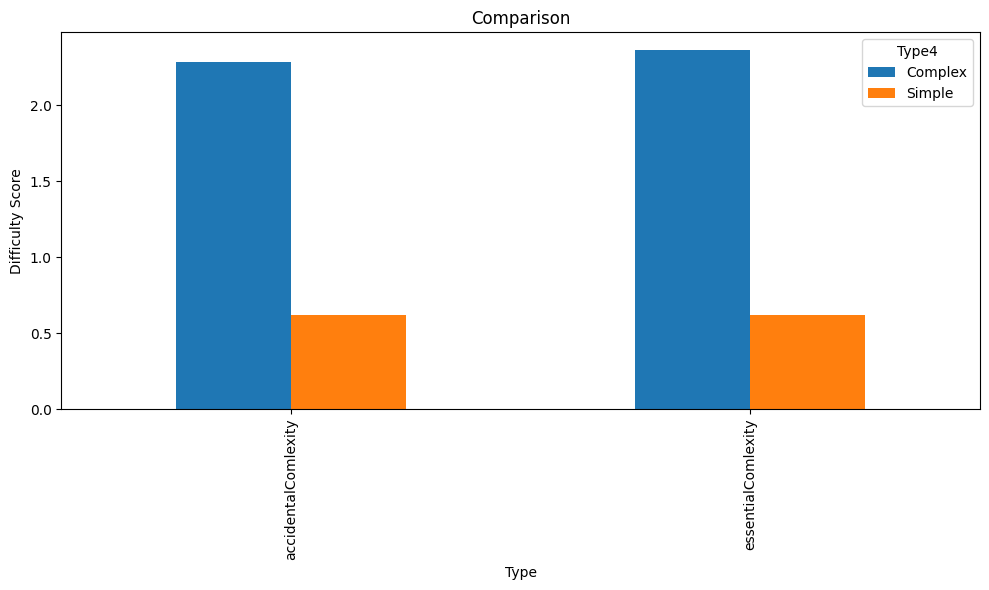

In [14]:
### PERCEIVED DIFFICULTY
measure = 'Difficulty Score'
col = 'difficultyScore'

means =compute_grouped_mean(perceivedDifficultyData, ['Type4','Type3'], ['participant', 'MainQuestionID'], col, additional_filters= {
    'Type1':'Coarse',
    })


# Pivot the table
pivot_df = means.pivot_table(index='Type3', columns='Type4', values=col)
# Display the pivoted data
display(pivot_df)

conditions = [('Complex', 'Simple')]
for type3 in ['essentialComlexity','accidentalComlexity']:
    print(type3)
    res = inf_test(perceivedDifficultyData, ['participant', 'ComparisionGroup','questionID','Type4','Type3'], col, 'Type4', conditions, additional_filters=
                                {
                                 'Type1': 'Coarse',
                                'Type3': type3})
    

comparison_survey = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

#### Performance Measures

Type4,Complex,Simple
Type3,,
accidentalComlexity,0.88,0.98
essentialComlexity,0.66,0.98


essentialComlexity
Complex  vs.  Simple


C:\Users\XXX\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


accidentalComlexity
Complex  vs.  Simple


C:\Users\XXX\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\XXX\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


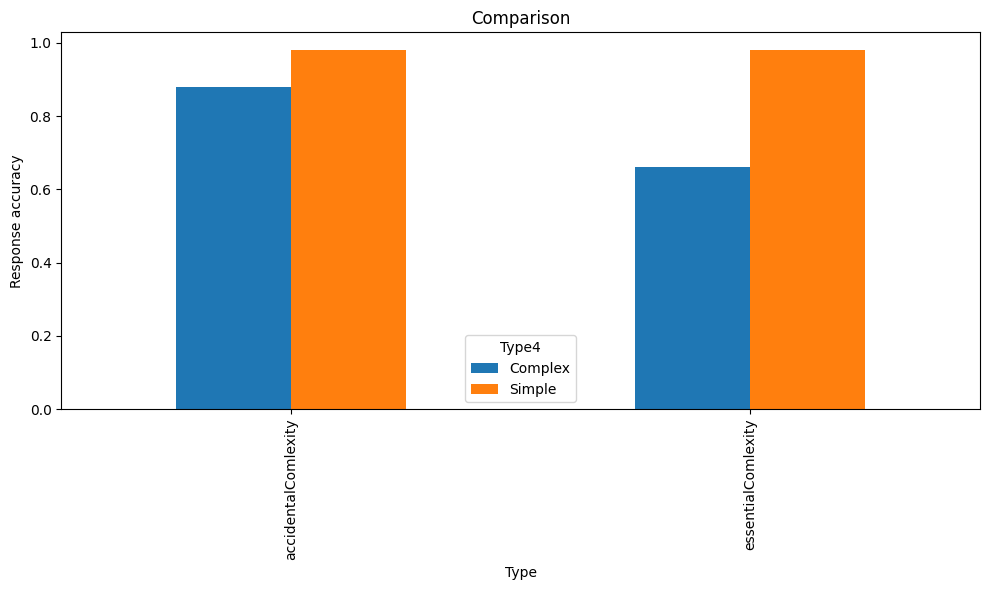

In [15]:
### Answer accuracy
measure = 'Response accuracy'
col = 'accuracy'

means =compute_grouped_mean(answersData, ['Type4','Type3'], ['participant', 'questionID'], col, additional_filters= {
    'Type1':'Coarse',
    })


# Pivot the table
pivot_df = means.pivot_table(index='Type3', columns='Type4', values=col)
# Display the pivoted data
display(pivot_df)

conditions = [('Complex', 'Simple')]
for type3 in ['essentialComlexity','accidentalComlexity']:
    print(type3)
    res = inf_test(answersData, ['participant', 'ComparisionGroup','questionID','Type4','Type3'], col, 'Type4', conditions, additional_filters=
                                {
                                 'Type1': 'Coarse',
                                'Type3': type3})
    

comparison_answers = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

#may need more participants

Type4,Complex,Simple
Type3,,
accidentalComlexity,104020.01404,44938.544612
essentialComlexity,145137.36188,44938.544612


essentialComlexity
Complex  vs.  Simple


accidentalComlexity
Complex  vs.  Simple


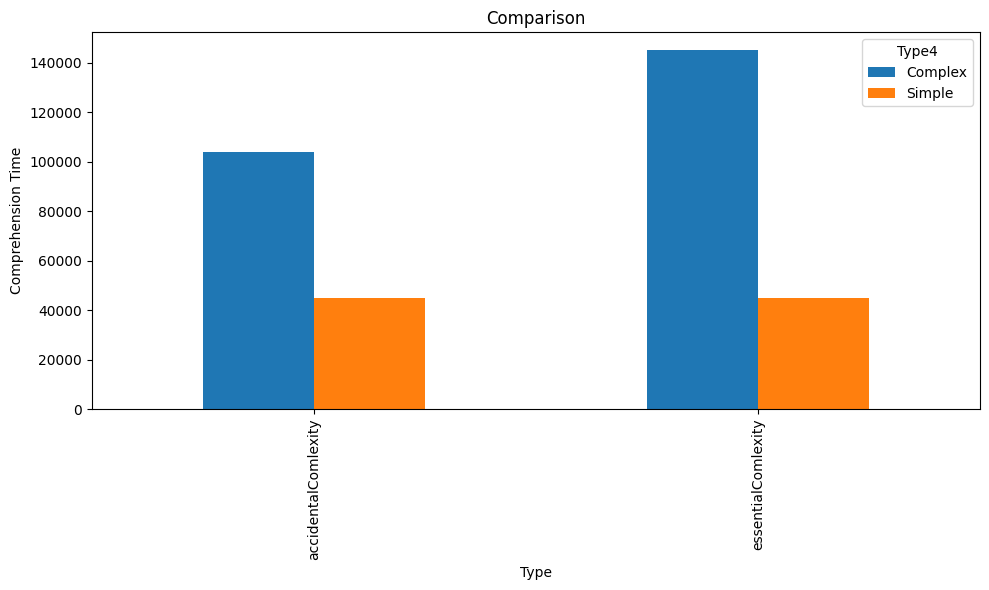

In [16]:
### Comprehension Time
#
# 
measure = 'Comprehension Time'
col = 'ComprehensionTime'

# Keep only MainQuestions
f_eifaData = eifaData[eifaData['Type2'] == 'MainQuestion'].copy(deep=True)

# Group 
f_eifaData_gr = f_eifaData.groupby(['participant','currentQuestion','Type1','Type2','Type3','Type4','ComparisionGroup'], as_index=False)

# Perform aggregations on grouping:
agg_f_eifaData = f_eifaData_gr.agg(
     newAggCol=('Timestamp', (lambda x: x.iloc[-1]-x.iloc[0])),
)
agg_f_eifaData.rename(columns={'newAggCol': col}, inplace=True)

#flatten
agg_f_eifaData = agg_f_eifaData.reset_index()


means = compute_grouped_mean(agg_f_eifaData, ['Type3','Type4'], ['participant', 'currentQuestion'], 
    measure_col = col,
    additional_filters = {
        'Type2':'MainQuestion',
        'Type1':'Coarse',
    })

# Pivot the table
pivot_df = means.pivot_table(index='Type3', columns='Type4', values=col)
# Display the pivoted data
display(pivot_df)

# to double check
conditions = [('Complex', 'Simple')]
for type3 in ['essentialComlexity','accidentalComlexity']:
    print(type3)
    res = inf_test(agg_f_eifaData, 
                   ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3'], 
                   col, 'Type4', conditions, 
                   additional_filters= {
                       'Type2': 'MainQuestion',
                       'Type1': 'Coarse',
                       'Type3': type3
                    }
    )

comparison_time = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

#### Behavioral Measures

Type4,Complex,Simple
Type3,,
accidentalComlexity,204.54,88.142857
essentialComlexity,232.12,88.163265


essentialComlexity
Complex vs. Simple


accidentalComlexity
Complex vs. Simple


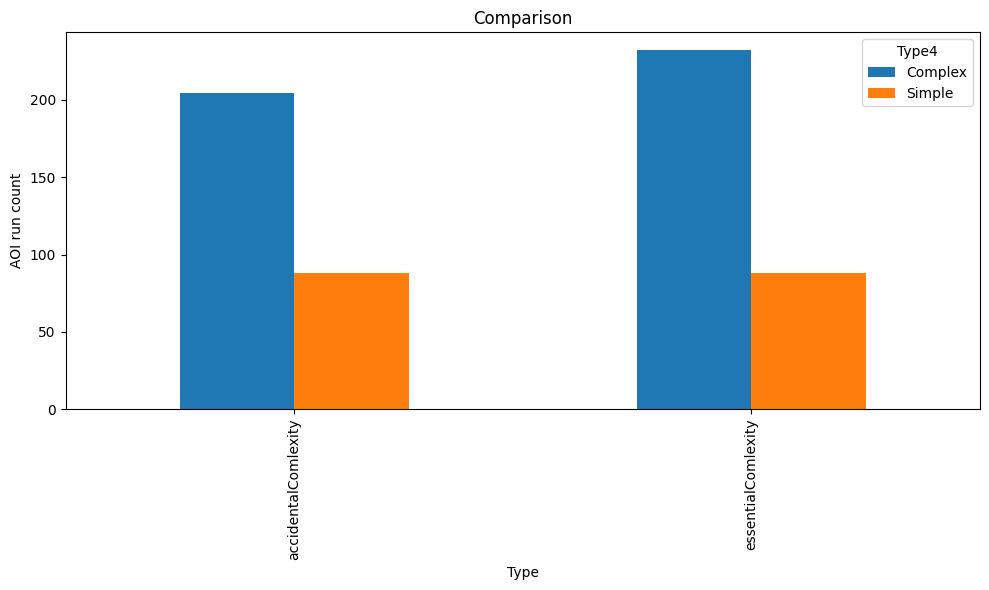

In [17]:
### Run count -> visual associations/ cognitive integration
measure = 'AOI run count'
col = 'AOIRunCount'

#detect dwells

# Keep only MainQuestions
f_eifaData = eifaData[eifaData['Type2'] == 'MainQuestion'].copy(deep=True)

#Keep only fixations
f_eifaData = f_eifaData.loc[(~f_eifaData['FixID'].isna()) & (~f_eifaData['currentQuestion'].isna())].copy(deep=True)

# Group by consecutive element and aggr by fixation Count -> obtained dwells
f_eifaData["elementCopy"] = f_eifaData["element"]
f_eifaData_gr = f_eifaData.groupby([(f_eifaData['elementCopy'].shift() != f_eifaData['elementCopy']).cumsum(),'element','tabName','participant','currentQuestion','Type1','Type2','Type3','Type4','ComparisionGroup'], as_index=False).agg(FixationCountPerDwell=('FixID', 'count'))

f_eifaData_gr = f_eifaData_gr.reset_index(drop=True)

#identify transitions
transitions = pd.DataFrame()
transitions[['participant','currentQuestion','Type1','Type3','Type4','tabName','TransitionSource','TransitionTarget','ComparisionGroup']] = f_eifaData_gr.apply(lambda x: identifyTransition(f_eifaData_gr,x.name), axis=1)

#keep only transitions from AOI to AOI
transitions = transitions[(~transitions['TransitionSource'].isna()) & (~transitions['TransitionTarget'].isna())]
transitions = transitions.reset_index(drop=True)

#add measure attribute
transitions[col] = 1

means = compute_grouped_mean_AOIRunCount(transitions, ['Type3','Type4'], ['participant', 'currentQuestion'], col, additional_filters= {
    'Type1':'Coarse',
    })

# Pivot the table
pivot_df = means.pivot_table(index='Type3', columns='Type4', values=col)
# Display the pivoted data
display(pivot_df)

conditions = [('Complex', 'Simple')]
for type3 in ['essentialComlexity','accidentalComlexity']:
    print(type3)
    res = inf_test_AOIRunCount(transitions, ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3'], col, 'Type4', conditions, additional_filters=
                                {
                                 'Type1': 'Coarse',
                                'Type3': type3})
    

comparison_runcount = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

Type4,Complex,Simple
Type3,,
accidentalComlexity,71.20,27.857143
essentialComlexity,85.52,27.857143


essentialComlexity
Complex  vs.  Simple


C:\Users\XXX\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


accidentalComlexity
Complex  vs.  Simple


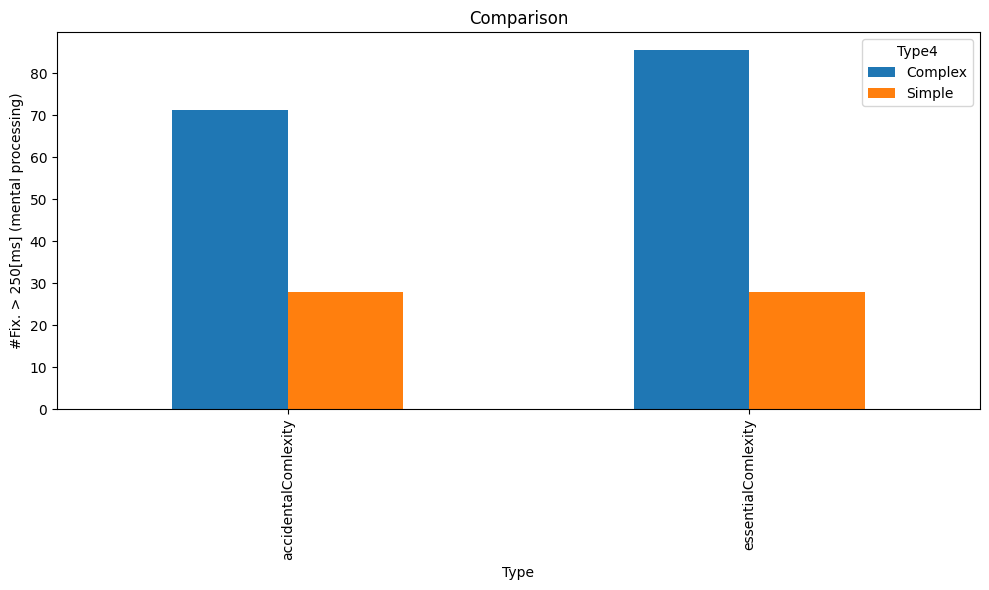

In [18]:
### AVERAGE COUNT OF FIXATIONS ABOVE 250MS (MENTAL PROCESSING)
measure = '#Fix. > 250[ms] (mental processing)'
col = 'Fixation Duration'

#select fixation data and drop na
fixationData = eifaData.loc[(~eifaData['FixID'].isna()) & (~eifaData['currentQuestion'].isna())].copy(deep=True)

#set fixation threshold
fixationData = fixationData[fixationData['Fixation Duration']>250]

means = compute_grouped_mean_fixationCount(fixationData, ['Type4','Type3'], ['participant', 'currentQuestion'], measure_col=col, additional_filters= {
    'Type2':'MainQuestion',
    'Type1':'Coarse',
    })

# Pivot the table
pivot_df = means.pivot_table(index='Type3', columns='Type4', values=col)
# Display the pivoted data
display(pivot_df)

conditions = [('Complex', 'Simple')]
for type3 in ['essentialComlexity','accidentalComlexity']:
    print(type3)
    res = inf_test_fixationCount(fixationData, ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3'], col, 'Type4', conditions, additional_filters=
                                {'Type2': 'MainQuestion',
                                 'Type1': 'Coarse',
                                 'Type3': type3})
    

comparison_cntfix250 = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

Type4,Complex,Simple
Type3,,
accidentalComlexity,11.877551,4.25
essentialComlexity,12.320000,4.25


essentialComlexity
Complex  vs.  Simple


C:\Users\XXX\AppData\Roaming\Python\Python310\site-packages\scipy\stats\_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


accidentalComlexity
Complex  vs.  Simple


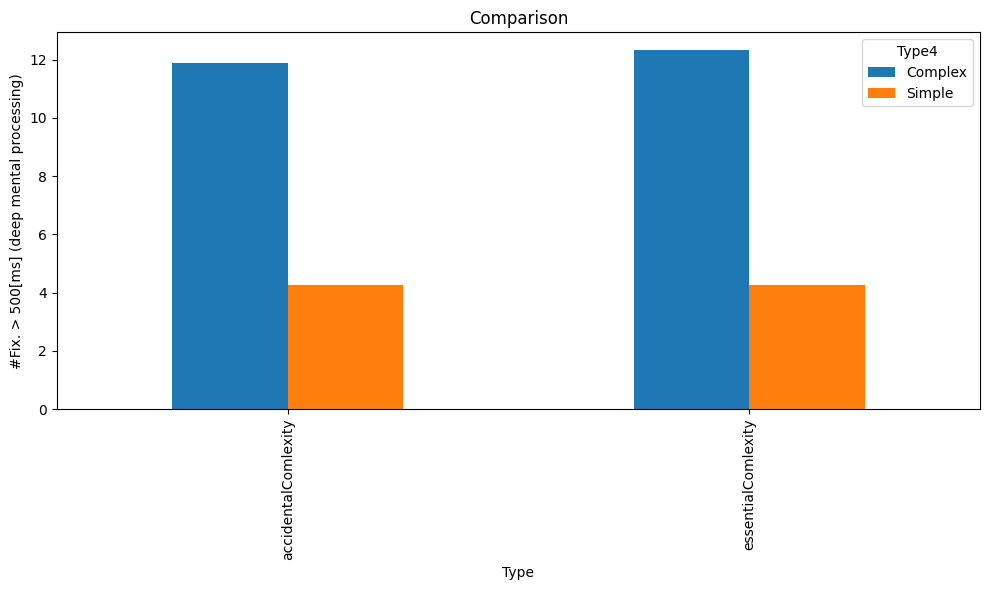

In [19]:
### AVERAGE COUNT OF FIXATIONS ABOVE 500MS (DEEP MENTAL PROCESSING)
measure = '#Fix. > 500[ms] (deep mental processing)'
col = 'Fixation Duration'

#select fixation data and drop na
fixationData = eifaData.loc[(~eifaData['FixID'].isna()) & (~eifaData['currentQuestion'].isna())].copy(deep=True)

#set fixation threshold
fixationData = fixationData[fixationData['Fixation Duration']>500]

means =compute_grouped_mean_fixationCount(fixationData, ['Type4','Type3'], ['participant', 'currentQuestion'], measure_col=col, additional_filters= {
    'Type2':'MainQuestion',
    'Type1':'Coarse',
    })

# Pivot the table
pivot_df = means.pivot_table(index='Type3', columns='Type4', values=col)
# Display the pivoted data
display(pivot_df)

conditions = [('Complex', 'Simple')]
for type3 in ['essentialComlexity','accidentalComlexity']:
    print(type3)
    res = inf_test_fixationCount(fixationData, ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3'], col, 'Type4', conditions, additional_filters=
                                {'Type2': 'MainQuestion',
                                 'Type1': 'Coarse',
                                 'Type3': type3})
    

comparison_cntfix500 = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

#### Physiological Measures

c:\DEV\NASSY\nassy-eyemind_plus-beta\utils\lhipa_utils.py:67: UserWarning: Input signal size (=91) lower than the minimum (=100). Returned NaN.
  warn(f'Input signal size (={len(d)}) lower than the minimum (={min_sample_size}). Returned NaN.')


Type4,Complex,Simple
Type3,,
accidentalComlexity,0.786028,1.320348
essentialComlexity,0.636281,1.320348


essentialComlexity
Complex  vs.  Simple


accidentalComlexity
Complex  vs.  Simple


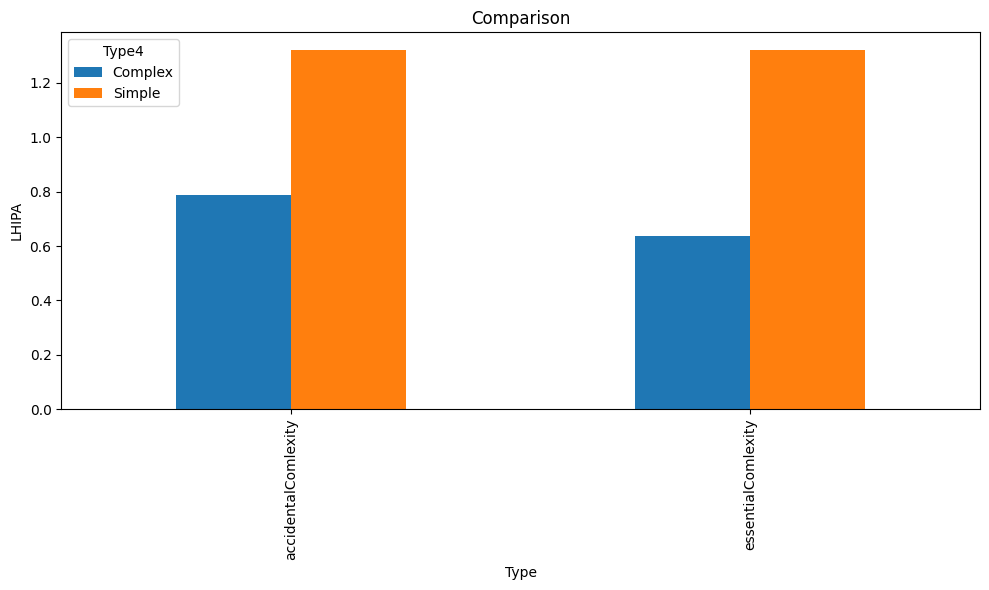

In [20]:
### LHIPA
measure = 'LHIPA'
col = 'LHIPA'

pupiFiltered_l = pupiFiltered[(pupiFiltered['Type2'] == 'MainQuestion') & (~pupiFiltered['tabName'].isna())].copy(deep=True)
pupiFiltered_l = pupiFiltered_l.groupby(['participant', 'currentQuestion', 'Type1', 'Type2','Type3','Type4','ComparisionGroup'])

# Compute LHIPA for each group
pupiFiltered_l = pupiFiltered_l.apply(compute_lhipa).reset_index()
pupiFiltered_l = pupiFiltered_l.rename(columns={0: col})
means = compute_grouped_mean(pupiFiltered_l, 
                             ['Type3','Type4'], 
                             ['participant', 'currentQuestion'], 
                             col, additional_filters= {'Type2':'MainQuestion', 'Type1':'Coarse', })

# Pivot the table
pivot_df = means.pivot_table(index='Type3', columns='Type4', values=col)
# Display the pivoted data
display(pivot_df)

# to double check
conditions = [('Complex', 'Simple')]
for type3 in ['essentialComlexity','accidentalComlexity']:
    print(type3)
    res = inf_test(pupiFiltered_l, ['participant', 'ComparisionGroup','currentQuestion','Type4','Type3'], col, 'Type4', conditions, additional_filters=
                                {
                                 'Type2': 'MainQuestion',
                                 'Type1': 'Coarse',
                                'Type3': type3})
    

comparison_lhipa = {'label': measure, 'means': means, 'pivot': pivot_df, 'measure': col}

plotComparison(pivot_df, measure)

### Summary
Bars of representative metrics (one for each categories). The expected tendencies for simple and complex tasks are indicated in the lengends as an arrow (pointing down for expected low value and conversely).

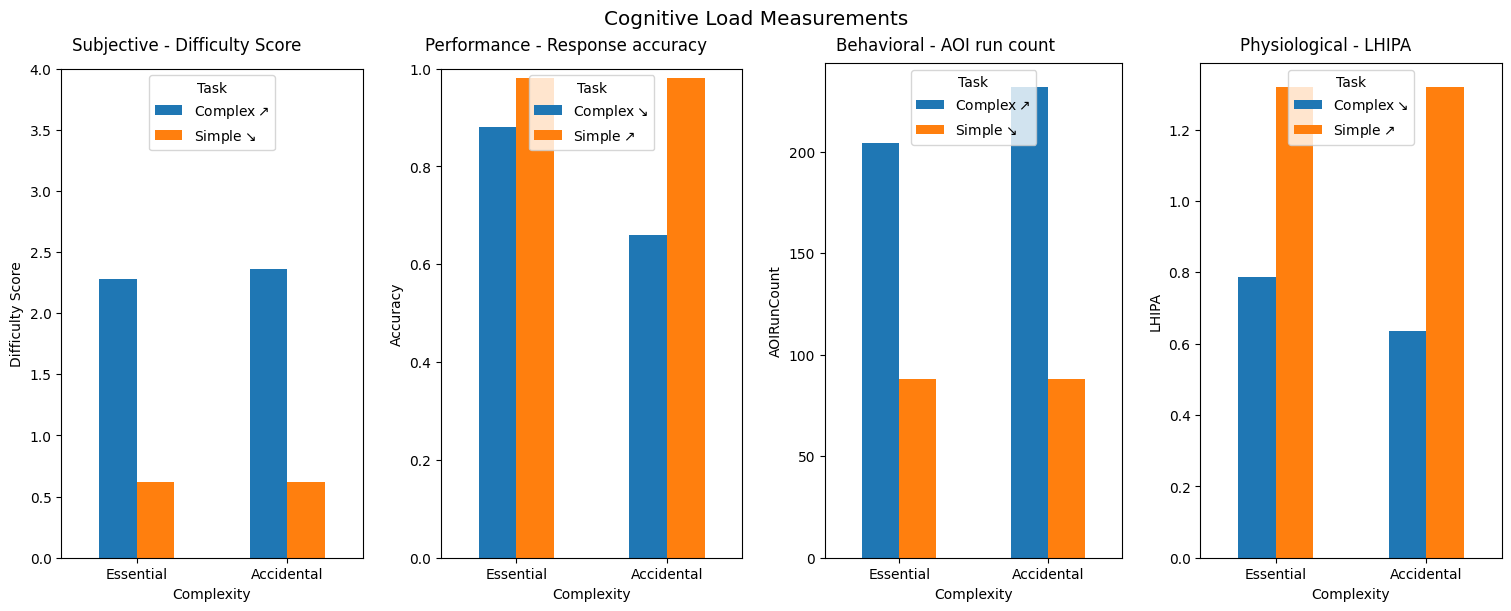

In [21]:
class MyBars4:
    kind = 'bar'

    def __init__(self, fig = None, ax = None):
        if fig is None or ax is None:
            self.fig = plt.figure(layout='constrained', figsize=(15, 6))
            self.ax = [None, None, None, None]
        else:
            self.fig, self.ax = fig, ax
        
        self.sf = self.fig.subfigures(1, 4, wspace=0.05)
        self.ax = [sf.subplots() for sf in self.sf]
        self.pivots = [None, None, None, None]
        self.measures = [None, None, None, None]

    # DEF: __init__

    def set_bar(self, pos, pivot, measure):
        if pos in range(4):
            self.pivots[pos] = pivot
            self.measures[pos] = measure

            self.pivots[pos].plot(kind=MyBars4.kind, ax=self.ax[pos])
            self.ax[pos].set_ylabel(self.measures[pos])
        else:
            raise IndexError('Position out of range (0:3).')
    # DEF: set_bar

    def set_title(self, pos, title):
        if not(pos in range(-1,4)): raise IndexError('Position out of range (-1:3).')

        if pos == -1: self.fig.suptitle(title, fontsize='x-large')
        else: self.sf[pos].suptitle(title)
    # DEF: set_title

    def set_label(self, pos, axis, label):
        if not(pos in range(4)): raise IndexError('Position out of range (0:3).')
        
        if (axis == 0) or (axis == 'x'):
            self.ax[pos].set_xlabel(label)
        elif (axis == 1) or (axis == 'y'):
            self.ax[pos].set_ylabel(label)
        else: raise IndexError(f'Unknown axis ({axis}).')
    # DEF: set_ylabel
    def set_ylabel(self, pos, label): self.set_label(pos, 1, label)
    def set_xlabel(self, pos, label): self.set_label(pos, 0, label)

# CLASS: MyBars4


myBars = MyBars4()
myBars.set_title(-1, 'Cognitive Load Measurements')

myBars.set_bar(0, comparison_survey['pivot'], comparison_survey['measure'])
myBars.set_xlabel(0, 'Complexity')
myBars.ax[0].set_xticks([0,1], labels=['Essential','Accidental'], rotation = 0)
myBars.set_ylabel(0, 'Difficulty Score')
myBars.set_title(0, 'Subjective - ' + comparison_survey['label'])
myBars.ax[0].set_ylim([0, 4])
myBars.ax[0].legend(title='Task', loc='upper center')
lg = myBars.ax[0].get_legend()
lg.get_texts()[0].set_text(lg.get_texts()[0].get_text() + r'$\nearrow$')
lg.get_texts()[1].set_text(lg.get_texts()[1].get_text() + r'$\searrow$')

myBars.set_bar(1, comparison_answers['pivot'], comparison_answers['measure'])
myBars.set_xlabel(1, 'Complexity')
myBars.ax[1].set_xticks([0,1], labels=['Essential','Accidental'], rotation = 0)
myBars.set_ylabel(1, 'Accuracy')
myBars.set_title(1, 'Performance - ' + comparison_answers['label'])
myBars.ax[1].set_ylim([0, 1])
myBars.ax[1].legend(title='Task', loc='upper center')
lg = myBars.ax[1].get_legend()
lg.get_texts()[0].set_text(lg.get_texts()[0].get_text() + r'$\searrow$')
lg.get_texts()[1].set_text(lg.get_texts()[1].get_text() + r'$\nearrow$')

myBars.set_bar(2, comparison_runcount['pivot'], comparison_runcount['measure'])
myBars.set_xlabel(2, 'Complexity')
myBars.ax[2].set_xticks([0,1], labels=['Essential','Accidental'], rotation = 0)
myBars.set_title(2, 'Behavioral - ' + comparison_runcount['label'])
myBars.ax[2].legend(title='Task', loc='upper center')
lg = myBars.ax[2].get_legend()
lg.get_texts()[0].set_text(lg.get_texts()[0].get_text() + r'$\nearrow$')
lg.get_texts()[1].set_text(lg.get_texts()[1].get_text() + r'$\searrow$')

# myBars.set_bar(3, comparison_cntfix250['pivot'], comparison_cntfix250['measure'])
# myBars.set_bar(3, comparison_cntfix500['pivot'], comparison_cntfix500['measure'])
myBars.set_bar(3, comparison_lhipa['pivot'], comparison_lhipa['measure'])
myBars.set_xlabel(3, 'Complexity')
myBars.ax[3].set_xticks([0,1], labels=['Essential','Accidental'], rotation = 0)
myBars.set_title(3, 'Physiological - ' + comparison_lhipa['label'])
myBars.ax[3].legend(title='Task', loc='upper center')
lg = myBars.ax[3].get_legend()
lg.get_texts()[0].set_text(lg.get_texts()[0].get_text() + r'$\searrow$')
lg.get_texts()[1].set_text(lg.get_texts()[1].get_text() + r'$\nearrow$')

plt.show()